In [62]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [63]:
df3= pd.read_csv('datatest2.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
df3 = df3.set_index(['date'])
df3.head()


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [64]:
del df3["HumidityRatio"]

In [65]:
ts=df3['CO2']

In [66]:
#index = pd.date_range(start=ts.index[0], end=ts.index[len(ts)-1], freq='T')
#index

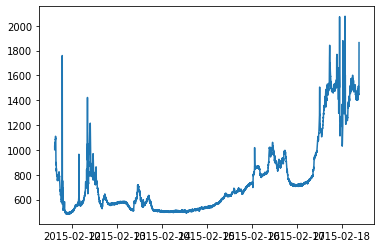

In [67]:
#ts = pd.Series(ts, index)
plt.plot(ts)
plt.show()

In [68]:
ts.head

<bound method NDFrame.head of date
2015-02-11 14:48:00    1029.666667
2015-02-11 14:49:00    1000.000000
2015-02-11 14:50:00    1003.750000
2015-02-11 14:51:00    1009.500000
2015-02-11 14:51:59    1005.666667
                          ...     
2015-02-18 09:15:00    1505.250000
2015-02-18 09:16:00    1514.500000
2015-02-18 09:16:59    1521.500000
2015-02-18 09:17:59    1632.000000
2015-02-18 09:19:00    1864.000000
Name: CO2, Length: 9752, dtype: float64>

### LOG TRANSFORMATION

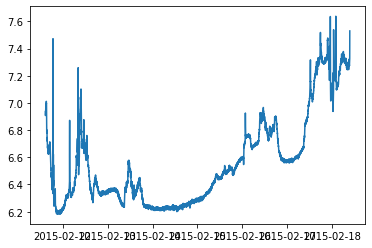

In [8]:
ts_log = pd.Series(np.log(ts), index=ts.index)
plt.plot(ts_log)
plt.show()

### DIFF TRANSFORMATION

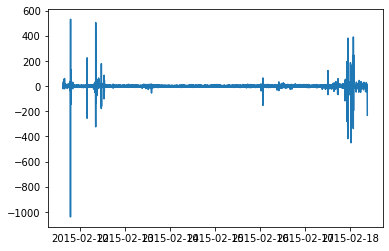

In [289]:
ts_diff = pd.Series(ts[:-1].values - ts[1:].values, index=ts.index[1:])
plt.plot(ts_diff)
plt.show()

### LOG MEAN AVERAGE TRANSFORMATION

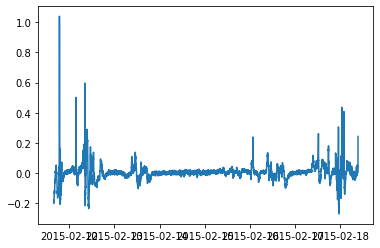

In [10]:
window = 60
ts_log_mov_diff = pd.Series(ts_log - ts_log.rolling(window, center=False).mean(), index=ts.index)
plt.plot(ts_log_mov_diff)
plt.show()

### Autocorrelation and PAC

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


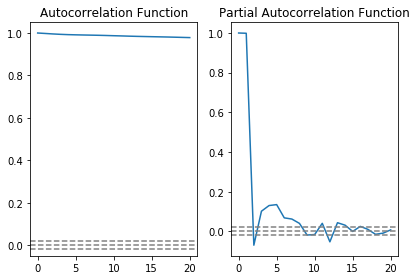

In [13]:
#ts=pd.to_datetime(ts)
lag_acf = acf(ts_log, nlags=20)
lag_pacf = pacf(ts_log, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

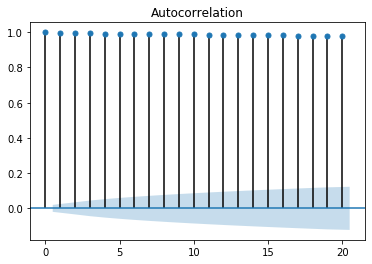

In [16]:
plot_acf(ts_log.values, lags=20)
plt.show()
#non è stazionarua, infatti c'è alta correlazione fra i lags

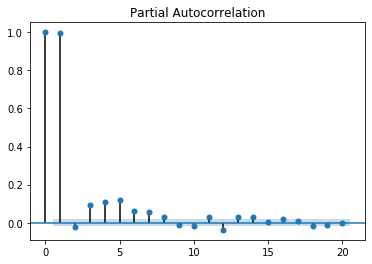

In [15]:
plot_pacf(ts_log.values, lags=20)
plt.show()

### Stationarity

In [187]:
from statsmodels.tsa.stattools import adfuller

In [18]:
dftest = adfuller(ts_log, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)
#Test statisic>critical value: non è stazionaria

Results of Dickey-Fuller Test:
Test Statistic                   -0.769233
p-value                           0.827993
#Lags Used                       24.000000
Number of Observations Used    9727.000000
Critical Value (1%)              -3.431022
Critical Value (5%)              -2.861837
Critical Value (10%)             -2.566928
dtype: float64


### Decomposition

In [189]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\monia\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


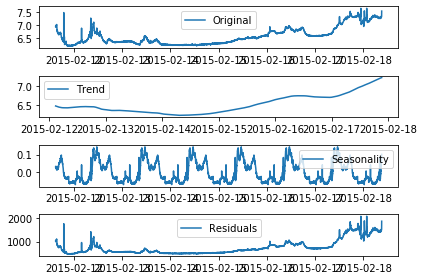

In [190]:
decomposition = seasonal_decompose(ts_log, freq=60*24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [193]:
dftest = adfuller(seasonal.values, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)
# se Test statistic > critical value, non è stazionaria
# seasonal è stazionario

Results of Dickey-Fuller Test:
Test Statistic                   -4.879599
p-value                           0.000038
#Lags Used                       38.000000
Number of Observations Used    9713.000000
Critical Value (1%)              -3.431023
Critical Value (5%)              -2.861838
Critical Value (10%)             -2.566928
dtype: float64


### Forecasting

In [12]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

### Forecasting su seasonal_ts_log

In [143]:
seasonal=decomposition.seasonal

In [144]:
index=pd.date_range(start=seasonal.index[0],end=seasonal.index[len(seasonal)-1], freq='T')
index
seasonal=pd.Series(seasonal, index)

In [145]:
#seasonal_ts_log=seasonal_ts_log.dropna()

In [146]:
split_index = 60*24*5
train_ts_log, test_ts_log= seasonal.iloc[:split_index], seasonal.iloc[split_index:]

train_ts_log_index=pd.date_range(start=train_ts_log.index[0],end=train_ts_log.index[len(train_ts_log)-1], freq='T')
train_ts_log=pd.Series(train_ts_log.values,train_ts_log_index)

test_ts_log_index=pd.date_range(start=test_ts_log.index[0],end=test_ts_log.index[len(test_ts_log)-1], freq='T')
test_ts_log=pd.Series(test_ts_log.values,test_ts_log_index)

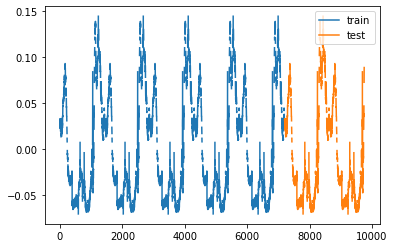

In [147]:
plt.plot(range(split_index), train_ts_log, label='train')
plt.plot(range(split_index, len(seasonal_ts_log)), test_ts_log, label='test')
plt.legend()
plt.show()

In [148]:
train_ts_log.index

DatetimeIndex(['2015-02-11 14:48:00', '2015-02-11 14:49:00',
               '2015-02-11 14:50:00', '2015-02-11 14:51:00',
               '2015-02-11 14:52:00', '2015-02-11 14:53:00',
               '2015-02-11 14:54:00', '2015-02-11 14:55:00',
               '2015-02-11 14:56:00', '2015-02-11 14:57:00',
               ...
               '2015-02-16 14:38:00', '2015-02-16 14:39:00',
               '2015-02-16 14:40:00', '2015-02-16 14:41:00',
               '2015-02-16 14:42:00', '2015-02-16 14:43:00',
               '2015-02-16 14:44:00', '2015-02-16 14:45:00',
               '2015-02-16 14:46:00', '2015-02-16 14:47:00'],
              dtype='datetime64[ns]', length=7200, freq='T')

In [157]:
train_ts_log=train_ts_log.fillna(method='backfill')

In [156]:
test_ts_log=test_ts_log.fillna(method='backfill')

In [154]:
test_ts_log.index

DatetimeIndex(['2015-02-16 14:48:00', '2015-02-16 14:49:00',
               '2015-02-16 14:50:00', '2015-02-16 14:51:00',
               '2015-02-16 14:52:00', '2015-02-16 14:53:00',
               '2015-02-16 14:54:00', '2015-02-16 14:55:00',
               '2015-02-16 14:56:00', '2015-02-16 14:57:00',
               ...
               '2015-02-18 09:10:00', '2015-02-18 09:11:00',
               '2015-02-18 09:12:00', '2015-02-18 09:13:00',
               '2015-02-18 09:14:00', '2015-02-18 09:15:00',
               '2015-02-18 09:16:00', '2015-02-18 09:17:00',
               '2015-02-18 09:18:00', '2015-02-18 09:19:00'],
              dtype='datetime64[ns]', length=2552, freq='T')

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


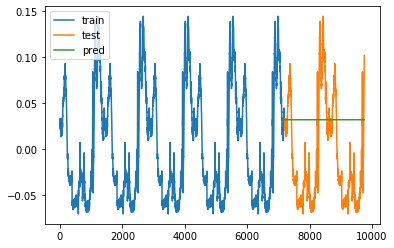

MAE 0.060
RMSE 0.067
MAD 0.066
R2 -0.593
MAPE 1.885
MAXAPE 3.510
TAPE 4810.652


In [171]:
smoothing_level = 1
ses = SimpleExpSmoothing(train_ts_log).fit(smoothing_level=smoothing_level, optimized=True)
pred_ts_log = ses.predict(start=test_ts_log.index[0], end=test_ts_log.index[-1])

plt.plot(range(len(train_ts_log)), train_ts_log, label='train')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(test_ts_log)), test_ts_log, label='test')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(pred_ts_log)), pred_ts_log, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test_ts_log, pred_ts_log, seasonal_ts_log).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


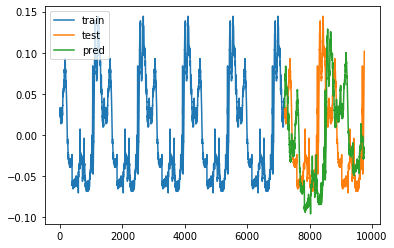

MAE 0.055
RMSE 0.072
MAD 0.042
R2 -0.823
MAPE 3.323
MAXAPE 1142.657
TAPE 8479.131


In [167]:
seasonal_periods=3000
es = ExponentialSmoothing(train_ts_log, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test_ts_log.index[0], end=test_ts_log.index[-1])

plt.plot(range(len(train_ts_log)), train_ts_log, label='train')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(test_ts_log)), test_ts_log, label='test')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test_ts_log, pred, seasonal_ts_log).items():
    print('%s %.3f' % (k, v))

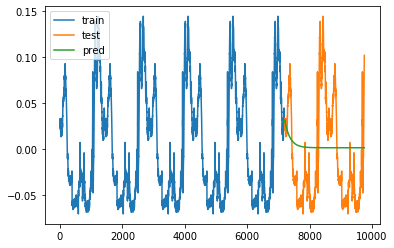

MAE 0.047
RMSE 0.053
MAD 0.046
R2 -0.009
MAPE 24.905
MAXAPE 88.955
TAPE 63556.525


In [202]:
arima = ARIMA(train_ts_log, order=(15,0,2)).fit()
pred = arima.predict(start=test_ts_log.index[0], end=test_ts_log.index[-1])

plt.plot(range(len(train_ts_log)), train_ts_log, label='train')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(test_ts_log)), test_ts_log, label='test')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test_ts_log, pred, seasonal_ts_log).items(): 
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


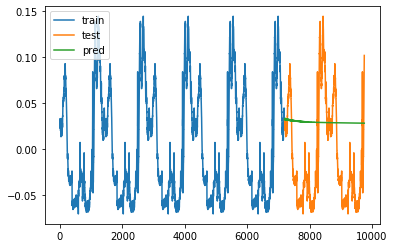

MAE 0.059
RMSE 0.065
MAD 0.064
R2 -0.511
MAPE 2.015
MAXAPE 3.972
TAPE 5143.037


In [194]:
sarimax = SARIMAX(train_ts_log, order=(2,0,1), seasonal_order=(2,0,1,12)).fit(disp=False)
pred = sarimax.predict(start=test_ts_log.index[0], end=test_ts_log.index[-1])

plt.plot(range(len(train_ts_log)), train_ts_log, label='train')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(test_ts_log)), test_ts_log, label='test')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test_ts_log, pred, seasonal_ts_log).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


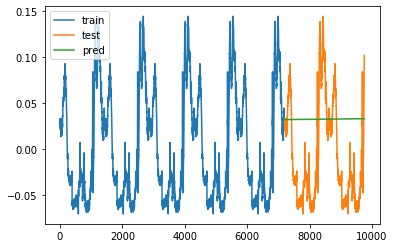

MAE 0.061
RMSE 0.067
MAD 0.066
R2 -0.614
MAPE 1.859
MAXAPE 3.426
TAPE 4744.641


In [254]:
smoothing_level=1.5
smoothing_slope=0.000009
#lavora bene se c'è seasonality
holt = Holt(train_ts_log).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
pred = holt.predict(start=test_ts_log.index[0], end=test_ts_log.index[-1])

plt.plot(range(len(train_ts_log)), train_ts_log, label='train')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(test_ts_log)), test_ts_log, label='test')
plt.plot(range(len(train_ts_log), len(train_ts_log)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test_ts_log, pred, seasonal_ts_log).items():
    print('%s %.3f' % (k, v))

### Forecasting su residual_ts_log

In [203]:
index = pd.date_range(start=residual.index[0], end=residual.index[len(residual)-1], freq='T')
index

DatetimeIndex(['2015-02-12 02:48:00', '2015-02-12 02:49:00',
               '2015-02-12 02:50:00', '2015-02-12 02:51:00',
               '2015-02-12 02:52:00', '2015-02-12 02:53:00',
               '2015-02-12 02:54:00', '2015-02-12 02:55:00',
               '2015-02-12 02:56:00', '2015-02-12 02:57:00',
               ...
               '2015-02-17 21:10:00', '2015-02-17 21:11:00',
               '2015-02-17 21:12:00', '2015-02-17 21:13:00',
               '2015-02-17 21:14:00', '2015-02-17 21:15:00',
               '2015-02-17 21:16:00', '2015-02-17 21:17:00',
               '2015-02-17 21:18:00', '2015-02-17 21:19:00'],
              dtype='datetime64[ns]', length=8312, freq='T')

In [125]:
residual = pd.Series(residual.values, index)

In [207]:
split_index = 60*24*5
train, test = residual.iloc[:split_index], residual.iloc[split_index:]

index = pd.date_range(start=train.index[0], end=train.index[len(train)-1], freq='T')
train= pd.Series(train.values, index)

index = pd.date_range(start=test.index[0], end=test.index[len(test)-1], freq='T')
test=pd.Series(test.values, index)

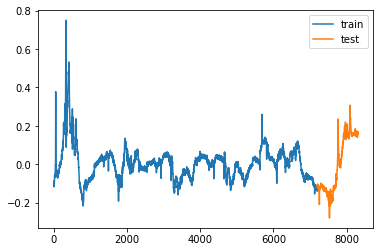

In [208]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(residual)), test, label='test')
plt.legend()
plt.show()

In [209]:
train.index

DatetimeIndex(['2015-02-12 02:48:00', '2015-02-12 02:49:00',
               '2015-02-12 02:50:00', '2015-02-12 02:51:00',
               '2015-02-12 02:52:00', '2015-02-12 02:53:00',
               '2015-02-12 02:54:00', '2015-02-12 02:55:00',
               '2015-02-12 02:56:00', '2015-02-12 02:57:00',
               ...
               '2015-02-17 02:38:00', '2015-02-17 02:39:00',
               '2015-02-17 02:40:00', '2015-02-17 02:41:00',
               '2015-02-17 02:42:00', '2015-02-17 02:43:00',
               '2015-02-17 02:44:00', '2015-02-17 02:45:00',
               '2015-02-17 02:46:00', '2015-02-17 02:47:00'],
              dtype='datetime64[ns]', length=7200, freq='T')

In [210]:
test.index

DatetimeIndex(['2015-02-17 02:48:00', '2015-02-17 02:49:00',
               '2015-02-17 02:50:00', '2015-02-17 02:51:00',
               '2015-02-17 02:52:00', '2015-02-17 02:53:00',
               '2015-02-17 02:54:00', '2015-02-17 02:55:00',
               '2015-02-17 02:56:00', '2015-02-17 02:57:00',
               ...
               '2015-02-17 21:10:00', '2015-02-17 21:11:00',
               '2015-02-17 21:12:00', '2015-02-17 21:13:00',
               '2015-02-17 21:14:00', '2015-02-17 21:15:00',
               '2015-02-17 21:16:00', '2015-02-17 21:17:00',
               '2015-02-17 21:18:00', '2015-02-17 21:19:00'],
              dtype='datetime64[ns]', length=1112, freq='T')

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


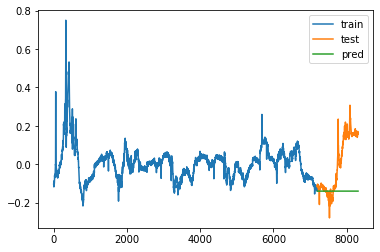

MAE 0.152
RMSE 0.202
MAD 0.133
R2 -0.978
MAPE 1.092
MAXAPE 3.210
TAPE 1214.392


In [219]:
smoothing_level = 1
ses = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


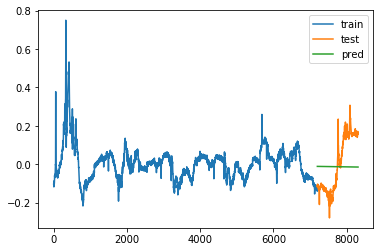

MAE 0.135
RMSE 0.145
MAD 0.137
R2 -0.023
MAPE 10.918
MAXAPE 24.146
TAPE 12140.272


In [264]:
smoothing_level=0.0009
smoothing_slope=0.0001
#lavora bene se c'è seasonality
holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
pred = holt.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


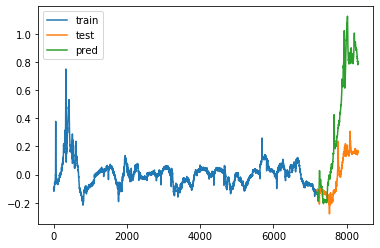

MAE 0.386
RMSE 0.474
MAD 0.324
R2 1.000
MAPE 2.266
MAXAPE 223.749
TAPE 2519.754


In [274]:
seasonal_periods=950
es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))

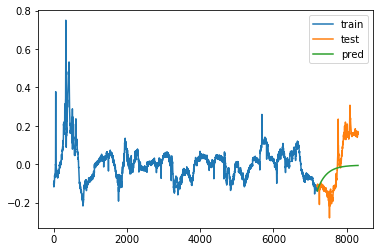

MAE 0.112
RMSE 0.129
MAD 0.113
R2 1.000
MAPE 10.181
MAXAPE 40.664
TAPE 11321.792


In [275]:
arima = ARIMA(train, order=(2,0,1)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items(): #su residual viene meglio 
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


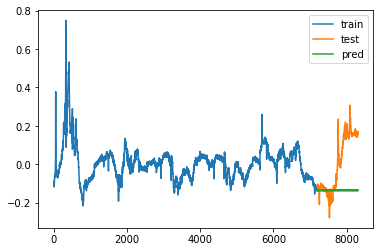

MAE 0.149
RMSE 0.199
MAD 0.128
R2 1.000
MAPE 1.106
MAXAPE 3.298
TAPE 1230.346


In [287]:
sarimax = SARIMAX(train, order=(2,0,1), seasonal_order=(5,1,0,3)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))

### ts_diff

In [290]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [291]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts_diff):
    mu = np.mean(ts_diff)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts_diff):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts_diff),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


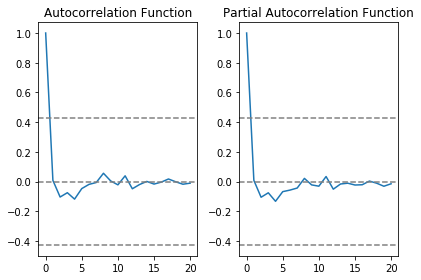

In [292]:
#ts=pd.to_datetime(ts)
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

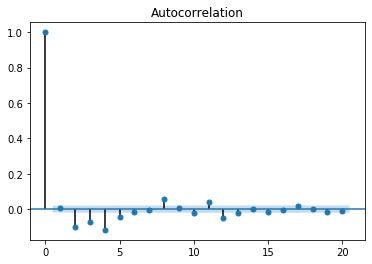

In [293]:
plot_acf(ts_diff, lags=20)
plt.show()

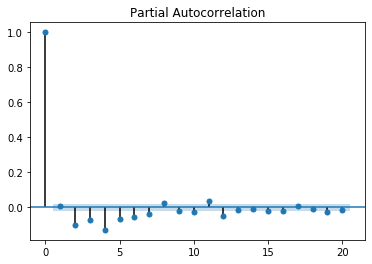

In [294]:
plot_pacf(ts_diff.values, lags=20)
plt.show()

In [295]:
from statsmodels.tsa.stattools import adfuller

In [296]:
dftest = adfuller(ts_diff, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -19.382097
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9712.000000
Critical Value (1%)              -3.431023
Critical Value (5%)              -2.861838
Critical Value (10%)             -2.566928
dtype: float64


In [297]:
from statsmodels.tsa.seasonal import seasonal_decompose

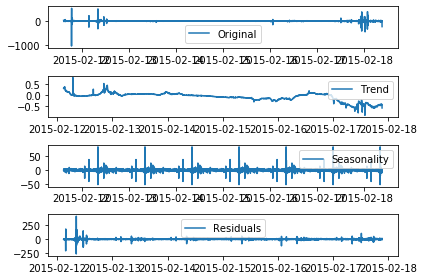

In [298]:
decomposition = seasonal_decompose(ts_diff, period=60*24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [299]:
residual=residual.dropna()
residual.head

<bound method NDFrame.head of date
2015-02-12 02:49:00    -0.897006
2015-02-12 02:50:00     3.887953
2015-02-12 02:51:00     2.467881
2015-02-12 02:51:59    -5.450902
2015-02-12 02:53:00     4.796648
                         ...    
2015-02-17 21:15:00     2.820654
2015-02-17 21:16:00    16.513329
2015-02-17 21:16:59     4.627396
2015-02-17 21:17:59     0.404899
2015-02-17 21:19:00    -6.147956
Name: resid, Length: 8311, dtype: float64>

In [300]:
dftest = adfuller(residual.values, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.594100e+01
p-value                        7.540874e-29
#Lags Used                     3.700000e+01
Number of Observations Used    8.273000e+03
Critical Value (1%)           -3.431141e+00
Critical Value (5%)           -2.861889e+00
Critical Value (10%)          -2.566956e+00
dtype: float64


In [344]:
index=pd.date_range(start=ts_diff.index[0],end=ts_diff.index[len(ts_diff)-1], freq='T')
index
ts_diff=pd.Series(ts_diff.values, index)

In [345]:
split_index = 60*24*5
train, test= ts_diff.iloc[:split_index], ts_diff.iloc[split_index:]

index=pd.date_range(start=train.index[0],end=train.index[len(train)-1], freq='T')
train=pd.Series(train.values,index)

index=pd.date_range(start=test.index[0],end=test.index[len(test)-1], freq='T')
test=pd.Series(test.values,index)

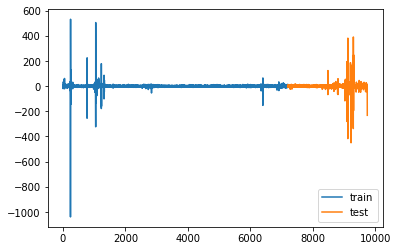

In [346]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(ts_diff)), test, label='test')
plt.legend()
plt.show()

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


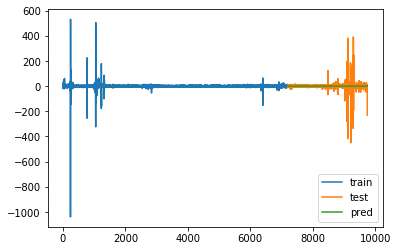

MAE 8.788
RMSE 28.973
MAD 3.767
R2 -0.000
MAPE 518.440
MAXAPE 26557.893
TAPE 1322539.669


In [347]:
ses = SimpleExpSmoothing(train).fit(optimized=True)
pred = ses.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


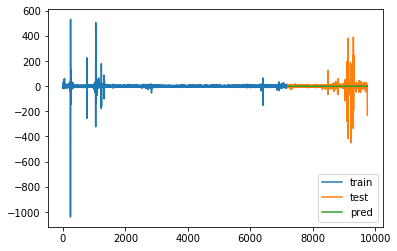

MAE 8.803
RMSE 28.971
MAD 3.750
R2 0.000
MAPE 15.090
MAXAPE 770.714
TAPE 38495.429


In [348]:
smoothing_level=1
smoothing_slope=0
holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope )
pred = holt.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


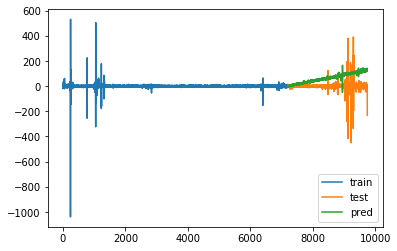

MAE 65.857
RMSE 80.173
MAD 61.899
R2 -6.658
MAPE 8.268
MAXAPE 18105.511
TAPE 21090.490


In [349]:
seasonal_periods=2550

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

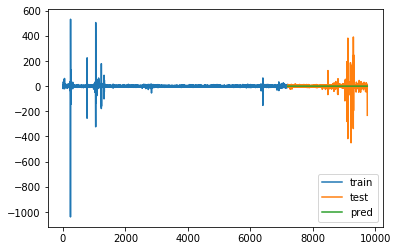

MAE 8.788
RMSE 28.973
MAD 3.766
R2 -0.000
MAPE 532.650
MAXAPE 27291.915
TAPE 1358790.156


In [350]:
arima = ARIMA(train, order=(2,0,0)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2095: RuntimeWarning: invalid value encountered in multiply
  endog = np.empty((nforecast, self.k_endog)) * np.nan


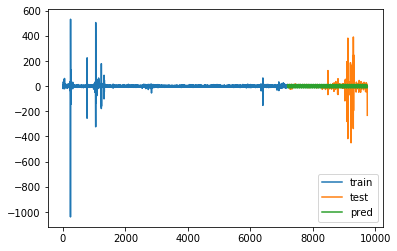

MAE 10.631
RMSE 29.566
MAD 5.750
R2 -0.041
MAPE 1400864.227
MAXAPE 725252699.887
TAPE 3573604643.756


In [52]:
sarimax = SARIMAX(train, order=(3,0,0), seasonal_order=(0, 1, 0, 60)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

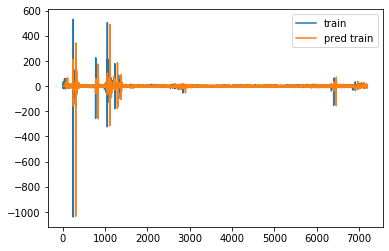

MAE 6.971
RMSE 26.234
MAD 3.779
R2 -0.865
MAPE inf
MAXAPE inf
TAPE inf


In [53]:
pred_train = sarimax.predict(start=train.index[0], end=train.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train)), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(train, pred_train, ts_diff).items():
    print('%s %.3f' % (k, v))

In [54]:
print(arima.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 7200
Model:                     ARMA(3, 0)   Log Likelihood              -31231.898
Method:                       css-mle   S.D. of innovations             18.519
Date:                Fri, 22 May 2020   AIC                          62473.797
Time:                        09:22:04   BIC                          62508.206
Sample:                    02-11-2015   HQIC                         62485.637
                         - 02-16-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0160      0.168      0.095      0.924      -0.313       0.345
ar.L1.y        0.0516      0.012      4.450      0.000       0.029       0.074
ar.L2.y       -0.1747      0.011    -15.279      0.0

### residual diff

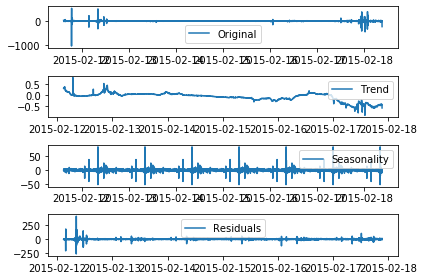

In [352]:
decomposition = seasonal_decompose(ts_diff, period=60*24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [371]:
residual=residual.dropna()
residual.head

2015-02-12 02:49:00    -2.296644
2015-02-12 02:50:00     5.212008
2015-02-12 02:51:00     4.708420
2015-02-12 02:52:00    -7.293634
2015-02-12 02:53:00     3.203472
                         ...    
2015-02-17 21:15:00     1.944213
2015-02-17 21:16:00    21.941464
2015-02-17 21:17:00     5.944792
2015-02-17 21:18:00    -0.021267
2015-02-17 21:19:00    -7.916348
Freq: T, Length: 8311, dtype: float64

In [354]:
index = pd.date_range(start=residual.index[0], end=residual.index[len(residual)-1], freq='T')
index

DatetimeIndex(['2015-02-12 02:49:00', '2015-02-12 02:50:00',
               '2015-02-12 02:51:00', '2015-02-12 02:52:00',
               '2015-02-12 02:53:00', '2015-02-12 02:54:00',
               '2015-02-12 02:55:00', '2015-02-12 02:56:00',
               '2015-02-12 02:57:00', '2015-02-12 02:58:00',
               ...
               '2015-02-17 21:10:00', '2015-02-17 21:11:00',
               '2015-02-17 21:12:00', '2015-02-17 21:13:00',
               '2015-02-17 21:14:00', '2015-02-17 21:15:00',
               '2015-02-17 21:16:00', '2015-02-17 21:17:00',
               '2015-02-17 21:18:00', '2015-02-17 21:19:00'],
              dtype='datetime64[ns]', length=8311, freq='T')

In [361]:
residual = pd.Series(residual.values, index)
new= pd.merge(residual, seasonal)

ValueError: Length of passed values is 8311, index implies 1111.

In [357]:
split_index = 60*24*5
train, test = residual.iloc[:split_index], residual.iloc[split_index:]
index=pd.date_range(start=train.index[0],end=train.index[len(train)-1], freq='T')
train=pd.Series(train.values,index)

index=pd.date_range(start=test.index[0],end=test.index[len(test)-1], freq='T')
test=pd.Series(test.values,index)

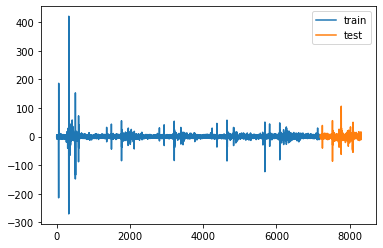

In [358]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(residual)), test, label='test')
plt.legend()
plt.show()

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


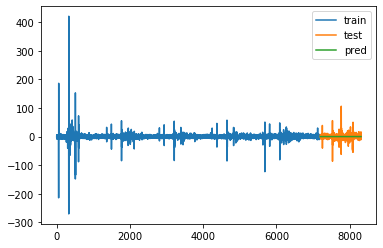

MAE 5.174
RMSE 9.335
MAD 3.133
R2 -0.000
MAPE 1242.692
MAXAPE 25459.436
TAPE 1380631.024


In [359]:
ses = SimpleExpSmoothing(train).fit(optimized=True)
pred = ses.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


MAE 5.166
RMSE 9.330
MAD 3.116
R2 0.001
MAPE 121.696
MAXAPE 55079.631
TAPE 135203.808


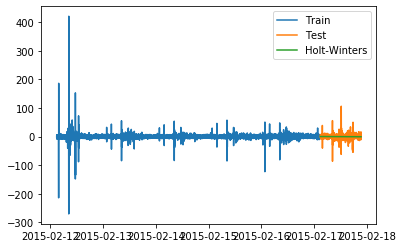

In [360]:
smoothing_level=0.05
smoothing_slope=0.01

holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope )
pred = holt.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best');

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


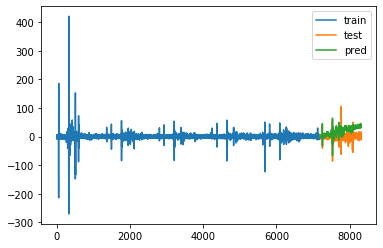

MAE 20.344
RMSE 24.891
MAD 18.665
R2 -6.112
MAPE 1.416
MAXAPE 108.264
TAPE 1572.858


In [63]:
seasonal_periods=60*24

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

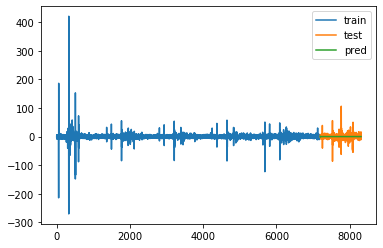

MAE 5.175
RMSE 9.335
MAD 3.133
R2 -0.000
MAPE 1248.132
MAXAPE 25606.157
TAPE 1386674.480


In [64]:
arima = ARIMA(train, order=(3,0,1)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

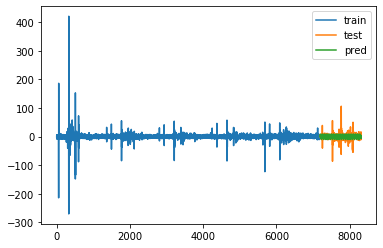

MAE 6.229
RMSE 10.053
MAD 4.332
R2 -0.160
MAPE 6.988
MAXAPE 318.031
TAPE 7763.991


In [65]:
sarimax = SARIMAX(train, order=(3,0,0), seasonal_order=(0, 1, 0, 60)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, residual).items():
    print('%s %.3f' % (k, v))

## ts_log_mov_diff

In [22]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error


def r2_score(y_true, y_pred, ts_log_mov_diff):
    mu = np.mean(ts_log_mov_diff)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts_log_mov_diff):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts_log_mov_diff),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

In [351]:
ts_log_mov_diff

NameError: name 'ts_log_mov_diff' is not defined

In [25]:
ts_log_mov_diff=ts_log_mov_diff.dropna()

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


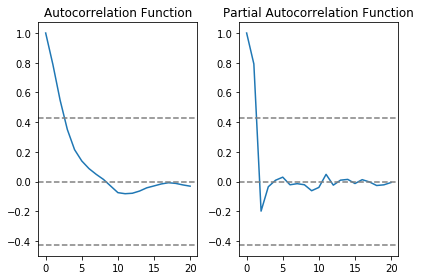

In [26]:
lag_acf = acf(ts_log_mov_diff.values[23:], nlags=20)
lag_pacf = pacf(ts_log_mov_diff[23:], nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_pacf)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

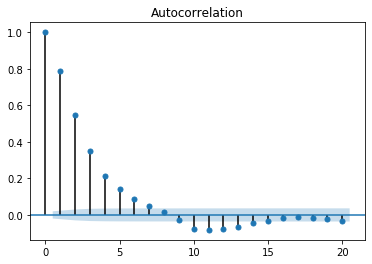

In [27]:
plot_acf(ts_log_mov_diff, lags=20)
plt.show()

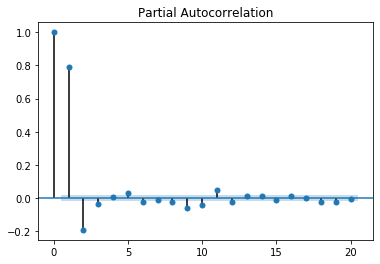

In [28]:
plot_pacf(ts_log_mov_diff.values, lags=20)
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(ts_log_mov_diff, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -19.162065
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    9716.000000
Critical Value (1%)              -3.431023
Critical Value (5%)              -2.861838
Critical Value (10%)             -2.566928
dtype: float64


In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

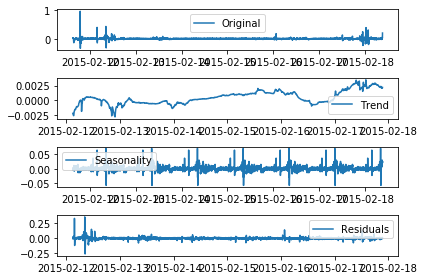

In [31]:
decomposition = seasonal_decompose(ts_log_mov_diff, period=60*24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_mov_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [79]:
dftest = adfuller(residual_mov_diff.values, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.272258e+01
p-value                        9.755217e-24
#Lags Used                     3.700000e+01
Number of Observations Used    8.215000e+03
Critical Value (1%)           -3.431146e+00
Critical Value (5%)           -2.861892e+00
Critical Value (10%)          -2.566957e+00
dtype: float64


In [48]:
index = pd.date_range(start=ts_log_mov_diff.index[0], end=ts_log_mov_diff.index[len(ts_log_mov_diff)-1], freq='T')
index

DatetimeIndex(['2015-02-11 14:58:59', '2015-02-11 14:59:59',
               '2015-02-11 15:00:59', '2015-02-11 15:01:59',
               '2015-02-11 15:02:59', '2015-02-11 15:03:59',
               '2015-02-11 15:04:59', '2015-02-11 15:05:59',
               '2015-02-11 15:06:59', '2015-02-11 15:07:59',
               ...
               '2015-02-18 09:09:59', '2015-02-18 09:10:59',
               '2015-02-18 09:11:59', '2015-02-18 09:12:59',
               '2015-02-18 09:13:59', '2015-02-18 09:14:59',
               '2015-02-18 09:15:59', '2015-02-18 09:16:59',
               '2015-02-18 09:17:59', '2015-02-18 09:18:59'],
              dtype='datetime64[ns]', length=9741, freq='T')

In [49]:
ts_log_mov_diff = pd.Series(ts_log_mov_diff.values, index)

In [50]:
split_index = 60*24*5
train, test = ts_log_mov_diff.iloc[:split_index], ts_log_mov_diff.iloc[split_index:]

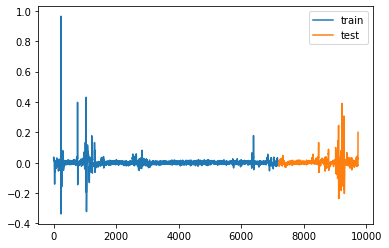

In [51]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(ts_log_mov_diff)), test, label='test')
plt.legend()
plt.show()

In [52]:
smoothing_level = 0.1
ses = SimpleExpSmoothing(train).fit(smoothing_level= smoothing_level, optimized=True)


C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


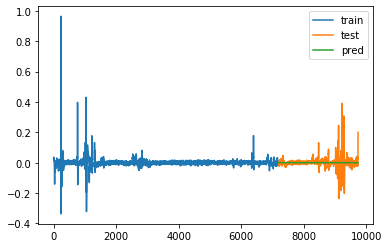

MAE 0.015
RMSE 0.032
MAD 0.008
R2 0.000
MAPE 39.756
MAXAPE 1005.727
TAPE 101019.658


In [55]:
pred = ses.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


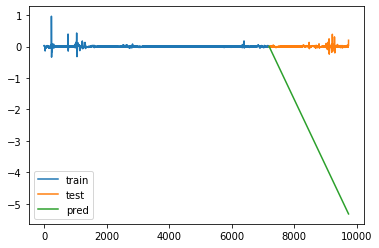

MAE 2.664
RMSE 3.076
MAD 2.666
R2 -9250.645
MAPE 0.999
MAXAPE 4.177
TAPE 2538.178


In [56]:
smoothing_level=0.58
smoothing_slope=0.58
holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
pred = holt.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


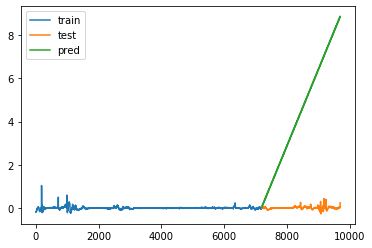

MAE 4.459
RMSE 5.131
MAD 4.420
R2 -8491.962
MAPE 0.998
MAXAPE 1.141
TAPE 2486.777


In [87]:
seasonal_periods=24

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

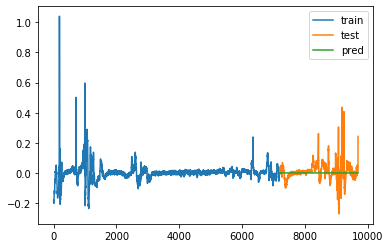

MAE 0.035
RMSE 0.056
MAD 0.021
R2 -0.005
MAPE 27345.964
MAXAPE 336333.642
TAPE 68173487.540


In [88]:
arima = ARIMA(train, order=(3,2,0)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

In [89]:
sarimax = SARIMAX(train, order=(3,2,0), seasonal_order=(3,2,0,60)).fit(disp=False) # per la p guardo la pcaf, per q guardo l'acf
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

KeyboardInterrupt: 

In [80]:
result=arima.summary()
print(arima.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 7199
Model:                 ARIMA(5, 1, 1)   Log Likelihood               18565.281
Method:                       css-mle   S.D. of innovations              0.018
Date:                Wed, 20 May 2020   AIC                         -37114.562
Time:                        15:23:55   BIC                         -37059.508
Sample:                    02-11-2015   HQIC                        -37095.618
                         - 02-16-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.779e-05      0.000      0.232      0.817      -0.000       0.000
ar.L1.D.y      0.6487      0.052     12.512      0.000       0.547       0.750
ar.L2.D.y     -0.1876      0.014    -13.238      0.0

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

### residual_mov_diff

In [46]:
index = pd.date_range(start=residual_mov_diff.index[0], end=residual_mov_diff.index[len(residual_mov_diff)-1], freq='T')
index

NameError: name 'residual_mov_diff' is not defined

In [47]:
residual_mov_diff = pd.Series(residual_mov_diff.values, index)

NameError: name 'residual_mov_diff' is not defined

In [200]:
split_index = 60*24*5
train, test = residual_mov_diff.iloc[:split_index], residual_mov_diff.iloc[split_index:]

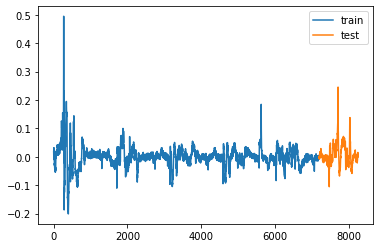

In [201]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(residual_mov_diff)), test, label='test')
plt.legend()
plt.show()

C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\monia\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


MAE 0.026
RMSE 0.037
MAD 0.018
R2 -0.087
MAPE 5.772
MAXAPE 48.347
TAPE 6078.296


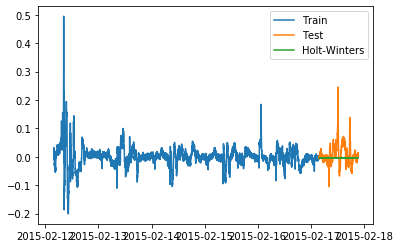

In [208]:
smoothing_level = 0.3
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=60).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

for k, v in evaluate(test, pred, residual_mov_diff).items():
    print('%s %.3f' % (k, v))